In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy import linalg as LA
import sys
#sys.path.append('/home/hhg/Research/CosmoLike/CosmoCov_Fourier/')
import cosmolike_libs_LSSTxSO_10x2pt as clike
import os
import importlib
import os.path

In [2]:
dir_data = '/home/hhg/Research/CosmoLike/CosmoCov_Fourier/data_emu/'

# -------------------------------------------------

ROMAN, ROMAN_WIDE = 1, 0
CMB_SO, CMB_S4 = 1, 0
ONESAMPLE = 0

# -------------------------------------------------

if (ROMAN):
    if (CMB_SO):
        full_fid_datav = '10x2pt_RomanxSO'
    else:
        full_fid_datav = '10x2pt_RomanxS4'
if (ROMAN_WIDE):
    if (CMB_SO):
        full_fid_datav = '10x2pt_RomanWidexSO'
    else:
        full_fid_datav = '10x2pt_RomanWidexS4'

if (ONESAMPLE):
    full_fid_datav = full_fid_datav + '_1sample'
    
full_mask = full_fid_datav + '_mask.txt'

# -------------------------------------------------

which_cmb = "so_Y5" # default
# RomanxSO / S4
if (ROMAN):
    source_z = 'zdistri_WFIRST_LSST_lensing_fine_bin_norm'
    lens_z = 'zdistri_WFIRST_LSST_clustering_fine_bin_norm'
    sigma_z_shear = 0.01
    sigma_z_clustering = 0.01
    if (CMB_SO):
        survey_designation = "RomanxSO"
    else:
        survey_designation = "RomanxS4"
        which_cmb = "s4"
    tomo_binning_source = "source_std"
    tomo_binning_lens = "WF_SN10"
    lmax_shear = 4000.0

# RomanWidexSO / S4
if (ROMAN_WIDE):
    source_z = 'zdistri_WFIRST_LSST_lensing_fine_bin_norm'
    lens_z = 'zdistri_WFIRST_LSST_clustering_fine_bin_norm'
    sigma_z_shear = 0.02
    sigma_z_clustering = 0.02
    if (CMB_SO):
        survey_designation = "RomanWidexSO"
    else:
        survey_designation = "RomanWidexS4"
        which_cmb = "s4"
    tomo_binning_source = "source_std"
    tomo_binning_lens = "WF_SN10"
    lmax_shear = 4000.0

if (ONESAMPLE):
    lens_z = source_z
    sigma_z_clustering = sigma_z_shear
    survey_designation = survey_designation + '_1sample'
    tomo_binning_lens = "lens=src"

file_source_z = os.path.join(clike.dirname, "zdistris/",source_z)
file_lens_z = os.path.join(clike.dirname, "zdistris/",lens_z)

# -------------------------------------------------
## not used for datav, just placeholder - don't delete!!
shear_prior=0.003
delta_z_prior_shear=0.001
delta_z_prior_clustering=0.001
sigma_z_prior_shear=0.003
sigma_z_prior_clustering=0.003
nsource_table=51.0  
nlens_table=66.0
area_table=2000.0
# -------------------------------------------------

clike.initcosmo("halomodel".encode('utf-8'))
clike.initbins(25,20.0,7979.0,lmax_shear,21.0,10,10)

clike.initpriors(shear_prior, sigma_z_shear, delta_z_prior_shear, sigma_z_prior_shear, sigma_z_clustering, delta_z_prior_clustering, sigma_z_prior_clustering)
clike.initsurvey(survey_designation.encode('utf-8'), nsource_table, nlens_table, area_table)
clike.initgalaxies(file_source_z.encode('utf-8'), file_lens_z.encode('utf-8'), "gaussian".encode('utf-8'), "gaussian".encode('utf-8'), tomo_binning_source.encode('utf-8'), tomo_binning_lens.encode('utf-8'))
clike.initia("NLA_z".encode('utf-8'), "none".encode('utf-8'))

clike.initprobes("10x2pt".encode('utf-8'))
clike.initcmb(which_cmb.encode('utf-8'))
clike.initfb(1)

0

In [3]:
inp = clike.InputNuisanceParams()

if (ROMAN or ROMAN_WIDE): # Roman lens sample, gbias = 1.3 + 0.1*i, bin index i=0~9
    inp.bias[:] = [1.3 + 0.1*i for i in range(10)]
    if ROMAN:
        inp.source_z_s = 0.01
        inp.lens_z_s = 0.01
        src_z_s_fid, lens_z_s_fid = 0.01, 0.01
    else:
        inp.source_z_s = 0.02
        inp.lens_z_s = 0.02
        src_z_s_fid, lens_z_s_fid = 0.02, 0.02
        
    if (ONESAMPLE): # gbias use gold sample formula
        inp.lens_z_s = inp.source_z_s
        lens_z_s_fid = src_z_s_fid
        inp.bias[:] = [1.166664, 1.403981, 1.573795, 1.744325, 1.925937, 2.131001, 2.370211, 2.651007, 3.036247, 4.556622]


inp.source_z_bias[:] = [0 for _ in range(10)]
inp.lens_z_bias[:] = [0 for _ in range(10)]
inp.shear_m[:] = [0 for _ in range(10)]
inp.A_ia = 0.5
inp.eta_ia = 0.0
inp.gas[:] = [1.17, 0.6, 14., 1., 0.03, 12.5, 1.2, 6.5, 0.752, 0., 0.]

In [4]:
omega_m = 0.3156
sigma_8 = 0.831
n_s = 0.9645
omega_b = 0.0491685
h0 = 0.6727
w0 = -1.
wa = 0.0
MGSigma = MGmu = 0

icp = clike.InputCosmologyParams(omega_m, sigma_8, n_s, w0, wa, omega_b, h0, MGSigma, MGmu)

In [5]:
ID = 0
dv_filename = f'emu_{ID}'
clike.compute_data_vector(dv_filename.encode('utf-8'), icp, inp)

print('--- data vector file created! ---')

--- data vector file created! ---


In [6]:
full_dv_filename = 'datav/10x2pt_'+dv_filename
datav = np.loadtxt(full_dv_filename)[:,1]
print(full_dv_filename)

datav/10x2pt_emu_0


In [7]:
N_10x2pt = datav.size
N_len = N_src = 10
N_ell = 25
N_ss = N_src * (N_src + 1) // 2
N_shear = N_ss * N_ell
N_6x2pt = N_10x2pt - (N_len + N_src + 2) * N_ell
N_3x2pt = N_6x2pt - (N_len + N_src + 1) * N_ell
N_8x2pt = N_10x2pt - (N_len + 1) * N_ell
print(f'N_shear={N_shear}, N_3x2pt={N_3x2pt}, N_6x2pt={N_6x2pt}, N_10x2pt={N_10x2pt}, N_8x2pt={N_8x2pt}')

N_shear=1375, N_3x2pt=2425, N_6x2pt=2950, N_10x2pt=3500, N_8x2pt=3225


- To Create a mask, run
`python datav/mask_c_dv.py datavfile`

e.g. `python datav/mask_c_dv.py datav/10x2pt_emu_0`

In [8]:
maskv = np.loadtxt('datav/10x2pt_'+dv_filename+'_mask.txt')[:,1]

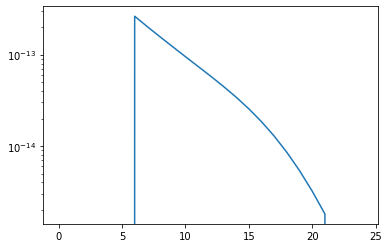

In [10]:
i = 130 ; s = 0
plt.plot(range(0,25), datav[25*i+s:25*(i+1)+s])
plt.yscale('log')

In [19]:
dv_filename = 'emu_0'
maskv0 = np.loadtxt('datav/10x2pt_'+dv_filename+'_mask.txt')[:,1]

dv_filename = 'emu_3'
maskv3 = np.loadtxt('datav/10x2pt_'+dv_filename+'_mask.txt')[:,1]

dv_filename = 'emu_140'
maskv140 = np.loadtxt('datav/10x2pt_'+dv_filename+'_mask.txt')[:,1]

In [20]:
print(np.where(maskv0 != maskv3))
print(np.where(maskv0 != maskv140))

(array([], dtype=int64),)
(array([], dtype=int64),)
